In [1]:
import utils
import pandas as pd
import importlib
import expert_factory
importlib.reload(expert_factory)
import numpy as np

In [2]:
def calcula_verossimilhanca(num_experts, y_true, output_experts, output_gating):
    py = np.zeros(shape=(len(y_true),num_experts))
    for expert in range(0,num_experts):
        for index,y in enumerate(y_true):
            #calcula a diff entre o real e o que o cada expert previu
            #diff = Ytr(j,:)-Yaux(j,:);
            diff = y - output_experts[index,expert]
            #Py(j,i)=exp(-diff*diff'/(2*var(i)));   
            py[index,expert] = np.exp(-np.dot(diff, diff.T) / (2))
    # Likelihood= sum(log(sum(Yg.*Py,2)));
    #haux = Yg.*Py;
    haux = np.multiply(output_gating, py)
    likelihood = np.sum(np.log(np.sum(haux,axis=1)))
    return likelihood,haux       

In [3]:
def output_final(X, gating_network, all_experts):
    #Calcula saida do gating
    gating_output = gating_network.feedforward(X)[-1]
    experts_outputs = []
    #calcula saida do experts
    for exp_net in all_experts:
        experts_outputs.append(exp_net.feedforward(X)[-1].tolist())
    #retorna o melhor expert como saida
    final_output = []
    for index_gate, result in enumerate(np.argmax(gating_output,axis=1)):
        final_output.append(experts_outputs[result][index_gate])
    return final_output
        

def maximiza_gating(gating_network, X, y, X_val, y_val,h):
    gating_network.train(X, y,
                         X_val, y_val,
                         numero_max_erro_val=10,
                         h_tipo='gat',
                         h=h,
                         plot=False)
    
def maximiza_expert(expert_network, X, y, X_val, y_val,h):
    expert_network.train(X, y,
                         X_val, y_val,
                         numero_max_erro_val=10,
                         h_tipo='exp',
                         h=h,
                         plot=False)

In [4]:
#Lendo o dadoa
df = pd.read_csv('data/treinamento-1.txt', header=None)

#normalizando o dado
df = utils.normalize_data(df)
num_lags = 15

#criando Lag
lagged_data = utils.create_lag(df, num_lags)
lagged_data = lagged_data.reset_index(drop=True)

X = lagged_data.drop(['y'],axis=1)
y = lagged_data['y']

#Criando conjunto de dados
fracao_dados_para_treino = 0.7
fracao_dados_para_teste = 0.2
X_train,y_train,X_test,y_test,X_val,y_val = utils.treino_teste_validacao(X,y, frac_train=fracao_dados_para_treino, frac_test=fracao_dados_para_teste)

Tamanho total 985
Tamanho treino 689
Tamanho teste 197
Tamanho validacao 99


In [6]:

all_ne = X_train.shape[1]
## Vamos criar alguns experts
all_experts = []
exp1 = expert_factory.Expert(ne=all_ne,nh=2,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=10000, alpha=0.015)
exp2 = expert_factory.Expert(ne=all_ne,nh=4,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=10000, alpha=0.025)
exp3 = expert_factory.Expert(ne=all_ne,nh=3,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=10000, alpha=0.055)
exp4 = expert_factory.Expert(ne=all_ne,nh=3,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=20000, alpha=0.3)
exp5 = expert_factory.Expert(ne=all_ne,nh=4,ns=1,g_h='tan_h',g_o='sigmoid',max_epoch=10000, alpha=0.6)

all_experts.append(exp1)
all_experts.append(exp2)
all_experts.append(exp3)
all_experts.append(exp4)
all_experts.append(exp5)


num_experts = len(all_experts)

In [8]:
#Criando rede gating   
gating_ne = X_train.shape[1]
gating_nh = 5
gating_ns = num_experts
gating_network = expert_factory.Expert(gating_ne,gating_nh,gating_ns, g_h='sigmoid', g_o='softmax',max_epoch=10000, alpha=0.02)

In [10]:
likelihood = 0
old_likelihood = -np.inf
iters = 0
max_iters = 1000
all_loss = []
all_likeli = []
while abs(likelihood-old_likelihood) > 1e-3 and iters < max_iters:
    iters += 1
    print(iters)
    #calcula a saida para cada rede
    #A funcao retorna 4 variaveis, queremos apenas a ultima que representa o output (por isso o [-1])
    output_gating = gating_network.feedforward(X_train)[-1]
    output_experts = np.matrix([np.ravel(expert.feedforward(X_train)[-1]).tolist() for expert in all_experts]).T
    #Agora que temos a saida comecamos com a funcao de EM
    old_likelihood = likelihood
    #Passo E (Expectation)
    #Com os parametros atuais calculamos calculamos a 'expectation' posterior para cada expert
    likelihood,haux_train = calcula_verossimilhanca(num_experts, y_train, output_experts, output_gating)
    #likelihood_val,haux_val = calcula_verossimilhanca(num_experts, y_train, output_experts, output_gating, matriz_covariancia)
    #h = haux./(sum(haux,2)*ones(1,m));
    h = np.divide(haux_train, np.dot(np.sum(haux_train,axis=1).reshape(haux_train.shape[0],1),np.ones((1,num_experts))))
    #Passo M (Maximizacao)
    maximiza_gating(gating_network, X_train, y_train, X_val, y_val,h)
    #Itera por cada expert o treinando com seu respectivo h
    for exp_index, expert in enumerate(all_experts):
        output_individual_exp = []
        for item in h[:,0]:
            output_individual_exp.append([item])
        maximiza_expert(expert, X_train, y_train, X_val, y_val,h=output_individual_exp)
    
    saida_final = output_final(X_train, gating_network, all_experts)
    erro = saida_final - y_train 
    loss = np.square(erro).mean()
    all_loss.append(loss)
    all_likeli.append(likelihood)
    print(loss)
    print(likelihood)

1


/home/favoretti/mestrado/data_mining/clods/mixture_of_experts/expert_factory.py:5: RuntimeWarning: overflow encountered in exp
  return (1.) / (1 + np.exp(-x))


0.165230155712
-4569.13489049
2
0.210793239027
-4582.16982275
3
0.240246832913
-4590.77753342
4
0.262370346572
-4590.99172723
5
0.280955130864
-4593.94798931
6
0.291176198289
-4600.74161374
7
0.295768737006
-4604.65462659
8
0.299951035202
-4606.12146744
9
0.301377818803
-4608.95205871
10
0.301194552921
-4610.57368363
11
0.301278136245
-4611.21926415
12
0.301094147141
-4612.15119014
13
0.300858751956
-4613.03789667
14
0.300616937721
-4613.95668626
15
0.300364143123
-4614.93802215
16
0.300112391111
-4615.96689667
17
0.299862386274
-4617.05190222
18
0.299615501076
-4618.18993158
19
0.299371937859
-4619.38003307
20
0.299131992176
-4620.62080978
21
0.298895796024
-4621.91084352
22
0.298663448275
-4623.24874531
23
0.298435010539
-4624.63318859
24
0.298210511708
-4626.06291007
25
0.297989952489
-4627.53669795
26
0.297773306065
-4629.05339707
27
0.297560520312
-4630.61190228
28
0.29735151935
-4632.21115666
29
0.29714620575
-4633.8501485
30
0.296944462898
-4635.52790886
31
0.296746157592
-4637.

0.263848651152
-5457.67853807
248
0.263627875392
-5462.86502776
249
0.263405596774
-5468.06096898
250
0.263181800226
-5473.26632699
251
0.262956470547
-5478.4810671
252
0.262729592401
-5483.70515462
253
0.262501150322
-5488.93855496
254
0.262271128706
-5494.18123352
255
0.262039511816
-5499.43315576
256
0.261806283778
-5504.69428717
257
0.261571428584
-5509.96459328
258
0.261334930086
-5515.24403966
259
0.261096771999
-5520.5325919
260
0.2608569379
-5525.83021564
261
0.260615411227
-5531.13687654
262
0.260372175279
-5536.45254029
263
0.260127213217
-5541.77717263
264
0.259880508059
-5547.11073932
265
0.259632042686
-5552.45320613
266
0.259381799839
-5557.80453889
267
0.259129762119
-5563.16470345
268
0.258875911984
-5568.53366568
269
0.258620231758
-5573.91139148
270
0.258362703622
-5579.29784678
271
0.25810330962
-5584.69299755
272
0.257842031655
-5590.09680976
273
0.257578851496
-5595.50924943
274
0.257313750772
-5600.93028259
275
0.257046710977
-5606.3598753
276
0.256777713469
-5611

0.140837891616
-6927.11687485
491
0.140231081497
-6933.88063526
492
0.139628205766
-6940.65043279
493
0.139029314449
-6947.42627057
494
0.138434455859
-6954.20815118
495
0.137843676585
-6960.99607669
496
0.137257021481
-6967.79004859
497
0.136674533662
-6974.59006786
498
0.136096254499
-6981.3961349
499
0.135522223617
-6988.20824958
500
0.134952478889
-6995.02641119
501
0.134387056442
-7001.85061851
502
0.133825990654
-7008.68086973
503
0.133269314159
-7015.51716249
504
0.132717057853
-7022.35949391
505
0.132169250896
-7029.20786052
506
0.131625920723
-7036.06225832
507
0.131087093053
-7042.92268277
508
0.130552791896
-7049.78912878
509
0.130023039568
-7056.66159072
510
0.129497856701
-7063.54006243
511
0.12897726226
-7070.4245372
512
0.128461273554
-7077.31500782
513
0.127949906257
-7084.21146654
514
0.127443174422
-7091.11390511
515
0.1269410905
-7098.02231474
516
0.126443665362
-7104.93668617
517
0.125950908314
-7111.85700963
518
0.125462827124
-7118.78327485
519
0.12497942804
-7125

0.0904636059623
-8682.9444681
730
0.0904411589696
-8690.71301474
731
0.0904190526434
-8698.48402607
732
0.0903972818092
-8706.25749415
733
0.0903758414111
-8714.03341113
734
0.0903547265129
-8721.81176921
735
0.0903339322999
-8729.59256064
736
0.0903134540803
-8737.37577776
737
0.0902932872879
-8745.16141295
738
0.0902734274848
-8752.94945867
739
0.0902538703646
-8760.73990745
740
0.0902346117573
-8768.53275186
741
0.0902156476332
-8776.32798458
742
0.0901969741102
-8784.12559833
743
0.0901785874601
-8791.92558591
744
0.0901604841175
-8799.72794019
745
0.0901426606904
-8807.53265413
746
0.0901251139727
-8815.33972077
747
0.0901078409593
-8823.14913322
748
0.0900908388644
-8830.96088469
749
0.0900741051443
-8838.7749685
750
0.0900576375247
-8846.59137804
751
0.0900414340347
-8854.41010685
752
0.0900254930496
-8862.23114858
753
0.0900098133442
-8870.05449701
754
0.0899943941609
-8877.8801461
755
0.0899792352965
-8885.70808997
756
0.0899643372168
-8893.53832297
757
0.0899497012069
-8901.3

0.0894523832036
-10572.0261064
966
0.0894508237067
-10580.2251301
967
0.0894492655207
-10588.4255218
968
0.0894477086429
-10596.6272789
969
0.0894461530708
-10604.8303986
970
0.0894445988019
-10613.0348782
971
0.0894430458335
-10621.2407151
972
0.0894414941632
-10629.4479064
973
0.0894399437885
-10637.6564497
974
0.0894383947067
-10645.8663421
975
0.0894368469153
-10654.0775809
976
0.0894353004119
-10662.2901637
977
0.0894337551939
-10670.5040876
978
0.0894322112587
-10678.7193501
979
0.089430668604
-10686.9359484
980
0.089429127227
-10695.1538801
981
0.0894275871255
-10703.3731424
982
0.0894260482968
-10711.5937327
983
0.0894245107385
-10719.8156485
984
0.0894229744481
-10728.0388872
985
0.0894214394231
-10736.263446
986
0.089419905661
-10744.4893226
987
0.0894183731593
-10752.7165143
988
0.0894168419157
-10760.9450185
989
0.0894153119275
-10769.1748327
990
0.0894137831925
-10777.4059543
991
0.089412255708
-10785.6383807
992
0.0894107294717
-10793.8721096
993
0.0894092044811
-10802.10

In [ ]:
import matplotlib.pyplot as plt

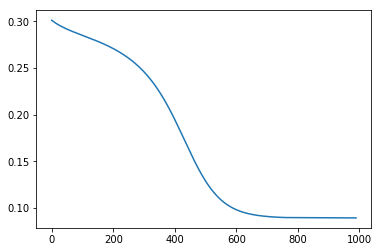

In [61]:
plt.plot(all_loss[10:])


In [43]:
X_train.shape[0]

689

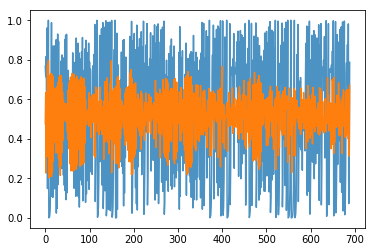

In [60]:
plt.plot(df[:y_train.shape[0]],alpha=0.8)
plt.plot(saida_final)


In [68]:
def test_network(gating_network,all_experts,X_test,y_test):
    saida_final = output_final(X_test, gating_network, all_experts)
    erro = saida_final - y_test 
    loss = np.square(erro).mean()
    return loss,saida_final

In [69]:
loss,saida_test = test_network(gating_network,all_experts,X_test,y_test)

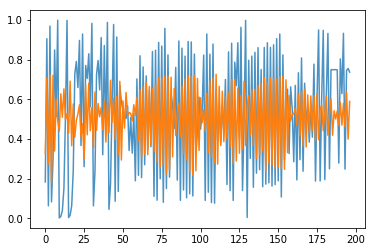

In [58]:
plt.plot(y_test,alpha=0.8)
plt.plot(saida_test)


In [32]:
def salva_pesos(network,type_net,filename):
    import json
    w = {}
    w["network"] = type_net
    w1 = {}
    w1["shape"] = network.W1.shape
    w1["pesos"] = network.W1.tolist()
    w["W1"] = w1
    
    b1 = {}
    b1["shape"] = network.b1.shape
    b1["pesos"] = network.b1.tolist()
    w["b1"] = b1
    
    w2 = {}
    w2["shape"] = network.W2.shape
    w2["pesos"] = network.W2.tolist()
    w["W2"] = w2
    
    b2 = {}
    b2["shape"] = network.b2.shape
    b2["pesos"] = network.b2.tolist()
    w["b2"] = b2
    
    with open(filename, "wb") as f:
        f.write(json.dumps(w).encode("utf-8"))

def import_network_object(network, filename):
    import pickle
    pickle.dump(network, open(filename, 'wb'))

In [72]:
#salvando pesos para arquivo final
salva_pesos(gt_n,'rede_gating', 'pesos_finais/rede_gating')
#salvando rede para objeto em arquivo
import_network_object(gating_network, 'redes_exportadas/rede_gating_pickle')

for i,exp in enumerate(all_experts):
    #salvando pesos experts
    salva_pesos(exp,'rede_expert', 'pesos_finais/rede_expert_{}'.format(i))
    #salvando objetos experts
    import_network_object(exp, 'redes_exportadas/rede_expert_pickle_{}'.format(i))
    